In [1]:
import nltk #Natural Language Toolkit
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
# split data into train and test set
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [5]:
# Create the numpy array of positive labels and negative labels.
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [6]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import string

def process_tweet(tweet):
    """
    Input:
        :tweet: a string
    Output:
        :tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) #the tokenizer will downcase everything except for emoticons
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and   # remove stopwords
                word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

In [8]:
def build_freqs(tweets, ys):
    """ Build frequencies
    Input:
    tweets: a list of tweets
    ys: an mx1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
    freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    yslist = np.squeeze(ys).tolist()
    # start with an empty dict and populate it by looping over all tweets
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [9]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11397


In [10]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    ''' 
    h = 1. / (1. + np.exp(-z))
    return h

In [11]:
import matplotlib.pyplot as plt

def gradient_descent_logistic(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix X
    m = len(x)
    losses = []
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = - (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) / float(m)
        losses.append(float(J))
        # update the weights theta
        theta = theta - (alpha * np.dot(x.T, (h-y))) / float(m)
    
    J = float(J)
    
    # plot the loss function
    iter_list = np.arange(1, num_iters + 1, 1)
    plt.plot(iter_list, losses, color='green', label='loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return J, theta

In [13]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """   
    # the list for storing predictions
    y_hat = list()
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)    
    return accuracy

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


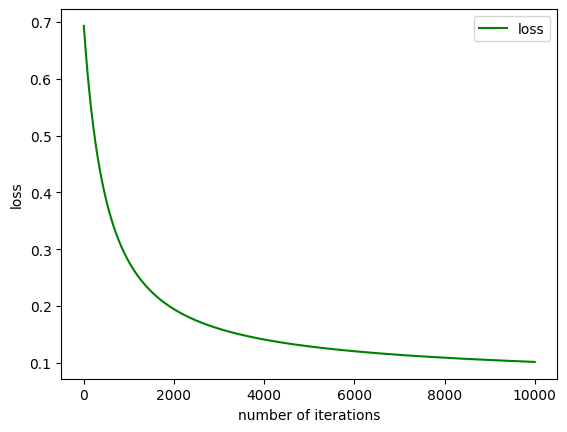

The cost after training is 0.10157921.
The resulting vector of weights is [3e-07, 0.00127323, -0.001111]
Logistic regression model's accuracy = 0.9960


In [14]:
def extract_2_features(tweet, freqs, process_tweet=process_tweet): #use for 2-feature model
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]
        
        # increment the word count for the negative label 0
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]
        
    assert(x.shape == (1, 3))
    return x
def predict_tweet_w2ft(tweet, freqs, theta): #use for 2-feature model
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_2_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_2_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((3, 1)), 1e-9, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet_w2ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")


### Q4 ### 

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


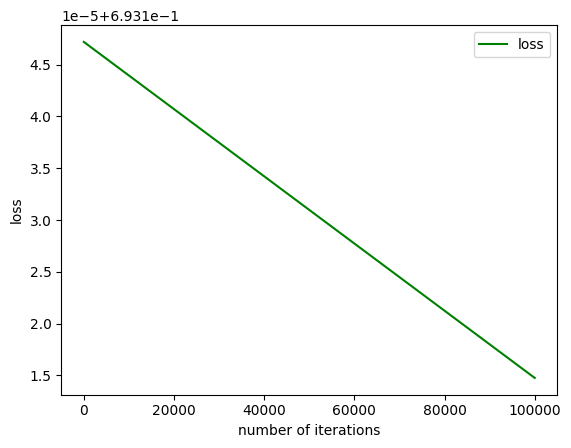

The cost after training is 0.69311476.
The resulting vector of weights is [0.0, 3.793e-05, -4.246e-05]
Logistic regression model's accuracy = 0.9955


In [26]:
#using standard scaler
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_2_features(train_x[i], freqs)
X_std = std_scaler.fit_transform(X)
Y = train_y
J, w = gradient_descent_logistic(X_std, Y, np.zeros((3, 1)), 1e-9, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet_w2ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")

After using StandardScaler: 
- The loss function become relatively linear within 100000 iterations with eta = 1e-8.
- The theta vector become smaller due to scaled data.
- The accuracy drops slightly for 0.05%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


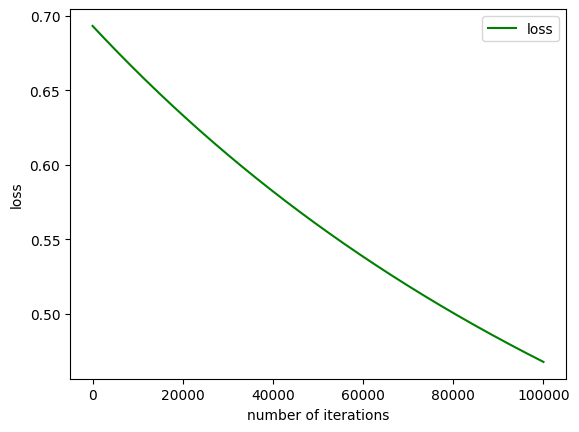

The cost after training is 0.46773037.
The resulting vector of weights is [0.0, 0.31155979, -0.35454645]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\1924491193.py:8: RuntimeWarning: overflow encountered in exp
  h = 1. / (1. + np.exp(-z))


Logistic regression model's accuracy = 0.9955


In [28]:
J, w = gradient_descent_logistic(X_std, Y, np.zeros((3, 1)), 1e-5, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet_w2ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")

When we increase alpha to 1e-5:
- The cost is further decreased.
- The convex of the loss function is more noticeable.
- The accuracy remain 99.55%

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


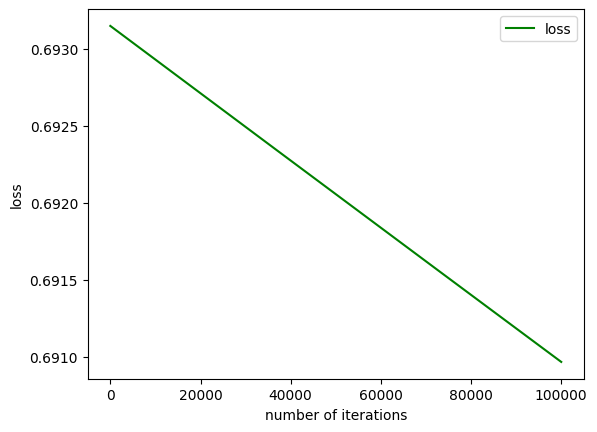

The cost after training is 0.69096633.
The resulting vector of weights is [0.0, 0.02595044, -0.03882589]
Logistic regression model's accuracy = 0.9905


In [33]:
#using MinMax scaler
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_2_features(train_x[i], freqs)
X_mm = minmax_scaler.fit_transform(X)
Y = train_y
J, w = gradient_descent_logistic(X_mm, Y, np.zeros((3, 1)), 1e-5, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet_w2ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")

Using MinMaxScaler, we notice a 0.5% drop in accuracy comparing to StandardScale

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


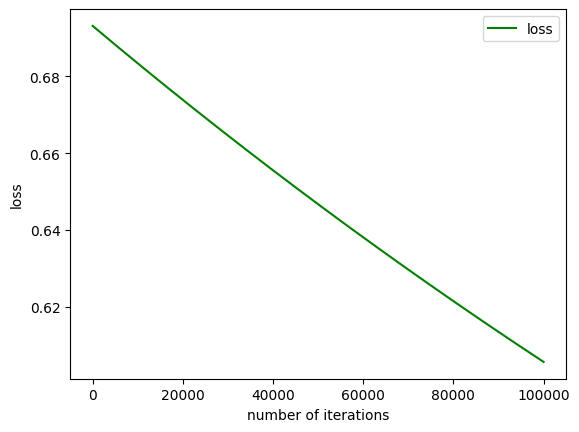

The cost after training is 0.60560120.
The resulting vector of weights is [0.0, 0.19650899, -0.22095362]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24856\1924491193.py:8: RuntimeWarning: overflow encountered in exp
  h = 1. / (1. + np.exp(-z))


Logistic regression model's accuracy = 0.9955


In [34]:
from sklearn.preprocessing import RobustScaler
rb_scaler = RobustScaler()
#using Robust scaler
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_2_features(train_x[i], freqs)
X_rb = rb_scaler.fit_transform(X)
Y = train_y
J, w = gradient_descent_logistic(X_rb, Y, np.zeros((3, 1)), 1e-5, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")
Z = test_logistic_regression(test_x, test_y, freqs, w, predict_tweet=predict_tweet_w2ft)
print(f"Logistic regression model's accuracy = {Z:.4f}")

RobustScaler gives the equal accuracy comparing to StandardScaler at 99.55%.